In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


PREPROCESSAMENTO DE DADOS - METODOLOGIA OROZCO LÓPEZ ET AL. (2024)

[ETAPA 1] Carregamento e Limpeza Inicial (Multi-arquivos de Meteorologia)
--------------------------------------------------------------------------------
Carregando dados de poluição (2018-2023 em um arquivo)...
✓ Poluição carregada: 52,584 registros.

Carregando e combinando dados meteorológicos (2018-2023)...
  - Carregado 1837178_-20.99_-51.58_2018.csv (8,760 registros).
  - Carregado 1837178_-20.99_-51.58_2019.csv (8,760 registros).
  - Carregado 1837178_-20.99_-51.58_2020.csv (8,760 registros).


/tmp/ipython-input-2782686851.py:92: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_meteo_ano.index = df_meteo_ano.index.floor('H')
/tmp/ipython-input-2782686851.py:92: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_meteo_ano.index = df_meteo_ano.index.floor('H')
/tmp/ipython-input-2782686851.py:92: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_meteo_ano.index = df_meteo_ano.index.floor('H')
/tmp/ipython-input-2782686851.py:92: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_meteo_ano.index = df_meteo_ano.index.floor('H')
/tmp/ipython-input-2782686851.py:92: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_meteo_ano.index = df_meteo_ano.index.floor('H')


  - Carregado 1837178_-20.99_-51.58_2021.csv (8,760 registros).
  - Carregado 1837178_-20.99_-51.58_2022.csv (8,760 registros).
  - Carregado 1837178_-20.99_-51.58_2023.csv (8,760 registros).

✓ Dados combinados: 52,586 registros
✓ Período: 2018-01-01 00:00:00 até 2024-01-01 01:00:00
✓ Colunas: ['pm25', 'temp', 'umidade', 'vento_dir', 'vento_vel']

[ETAPA 2] Análise de Dados Faltantes
--------------------------------------------------------------------------------

Estatísticas de Dados Faltantes:
           Total_Missing  Percent_Missing
pm25                   2             0.00
temp                  26             0.05
umidade               26             0.05
vento_dir             26             0.05
vento_vel             26             0.05


/tmp/ipython-input-2782686851.py:92: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_meteo_ano.index = df_meteo_ano.index.floor('H')



✓ Visualização salva em 'missing_data_pattern.png'

[ETAPA 3] Imputação de Dados Faltantes (MissForest)
--------------------------------------------------------------------------------
Seguindo Stekhoven & Bühlmann (2012) conforme artigo...

Iniciando imputação...
  Registros com missing: 28


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(



✓ Imputação concluída!
✓ Valores faltantes restantes: 0

[ETAPA 4] Criação de Features Temporais
--------------------------------------------------------------------------------
✓ Features temporais adicionadas
✓ Total de features: 15

Lista de features:
   1. pm25
   2. temp
   3. umidade
   4. vento_dir
   5. vento_vel
   6. hour_sin
   7. hour_cos
   8. day_sin
   9. day_cos
  10. month_sin
  11. month_cos
  12. is_weekend
  13. hour
  14. day_of_week
  15. month

[ETAPA 5] Divisão Temporal dos Dados
--------------------------------------------------------------------------------
Seguindo metodologia: últimos 2 anos para teste

✓ Dataset de Treino/Validação:
    Período: 2018-01-01 00:00:00 até 2023-07-05 00:00:00
    Registros: 48,265

✓ Dataset de Teste:
    Período: 2023-07-05 01:00:00 até 2024-01-01 01:00:00
    Registros: 4,321

[ETAPA 6] Normalização Zero-Mean
--------------------------------------------------------------------------------
✓ Normalização concluída
✓ Média do 

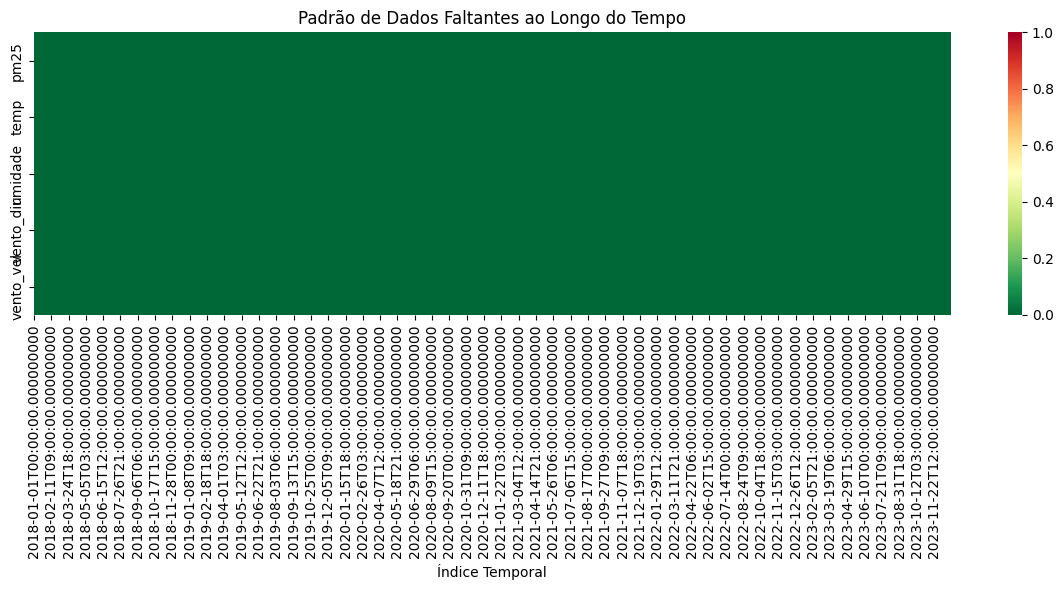

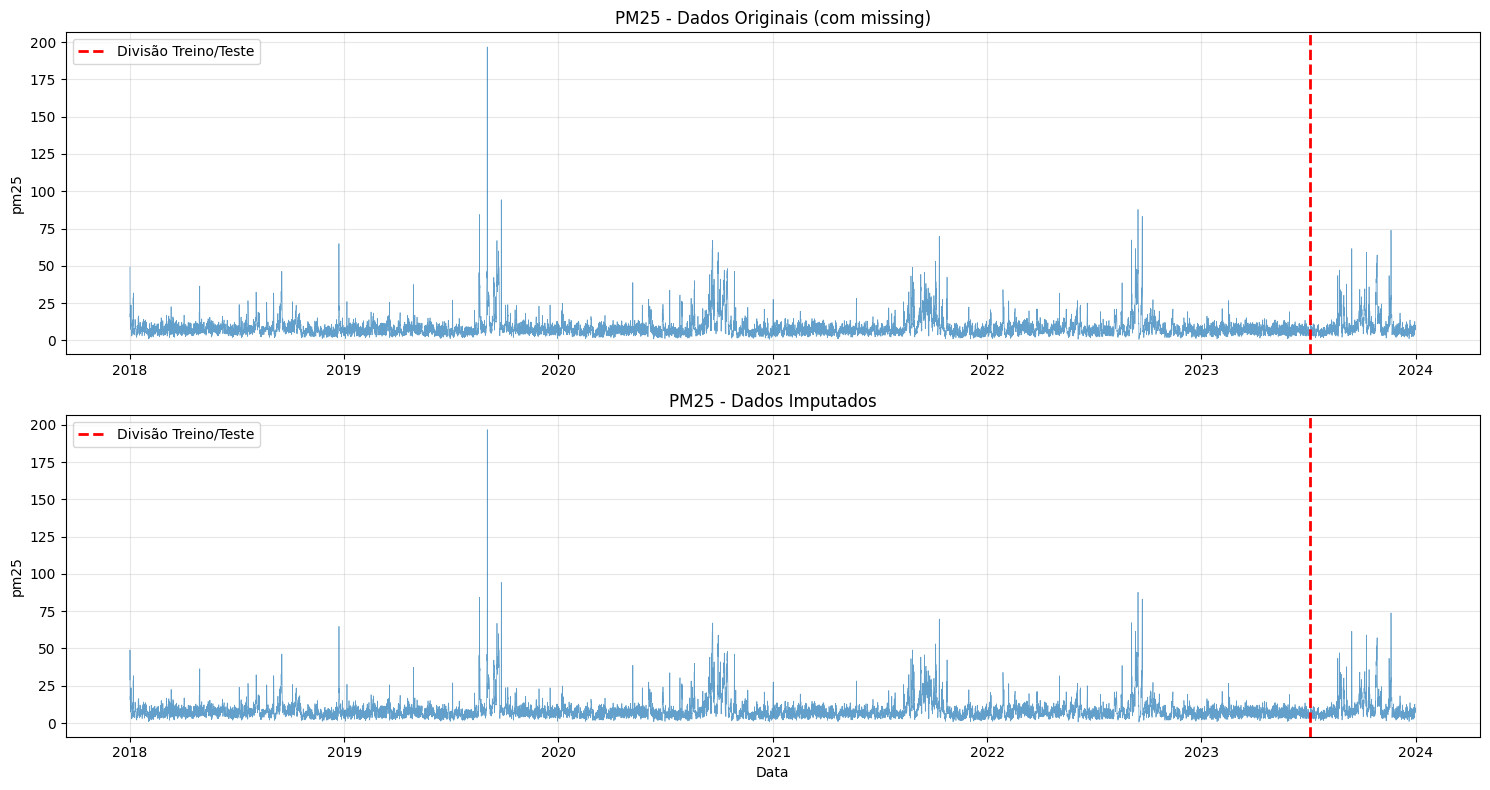

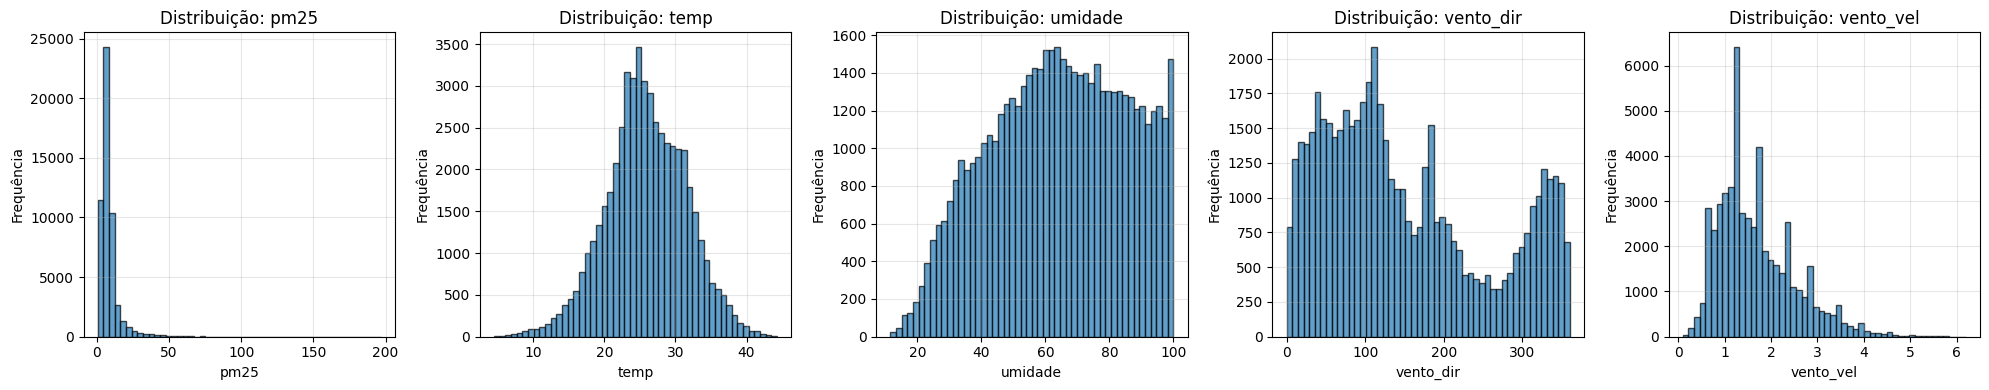

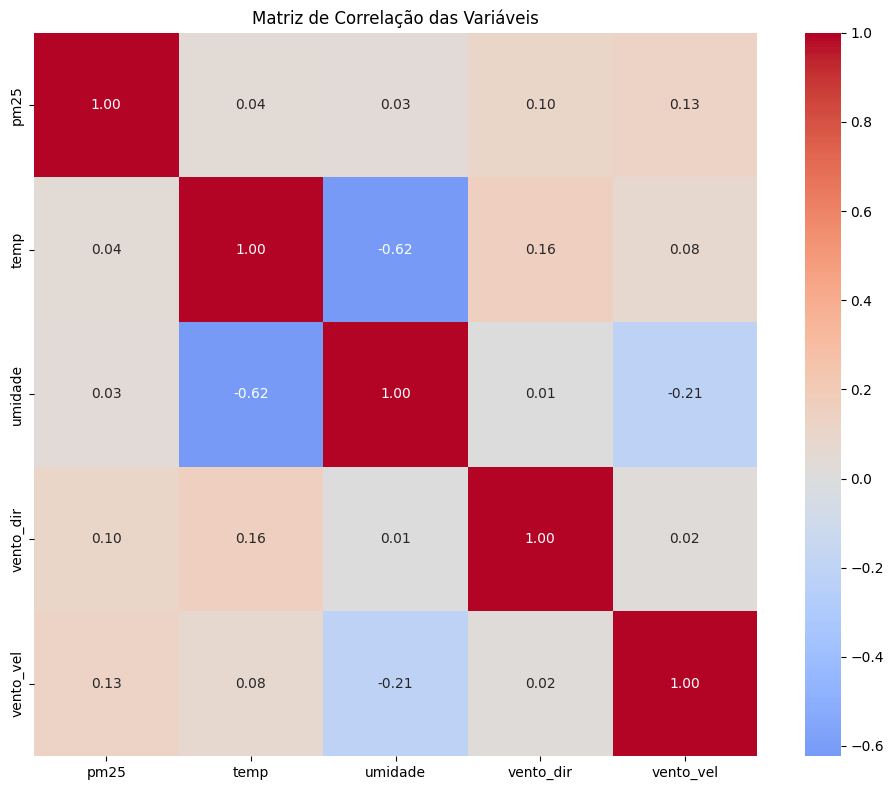

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from datetime import datetime, timedelta
import pickle

# ============================================================================
# CONFIGURAÇÕES INICIAIS
# ============================================================================

# Arquivos fornecidos pelo usuário
project_root = Path().resolve().parent
arq_poluicao = project_root / "content" /"drive"/"MyDrive" / "Paula" / "raw" / "Dracena" / "PM_Diario_Dracena_SP.csv"
#arq_poluicao = project_root / "content" /"drive"/"MyDrive" / "Paula" / "raw" / "Brasília" / "PM_Diario_Brasília_DF.csv"

anos = [2018, 2019, 2020, 2021, 2022, 2023]

# Base directory for meteorological files
meteo_base_dir = project_root / "content" / "drive" / "MyDrive" / "Paula" / "raw" / "Dracena"
#arq_poluicao = project_root / "content" /"drive"/"MyDrive" / "Paula" / "raw" / "Brasília" /

arquivos_meteo = []
for ano in anos:
    if ano == 2018:
        # Special filename for 2018
        arquivos_meteo.append(meteo_base_dir / "1837178_-20.99_-51.58_2018.csv")
    else:
        # General pattern for other years
        arquivos_meteo.append(meteo_base_dir / f"1837178_-20.99_-51.58_{ano}.csv")


# Lista de colunas numéricas finais após o pré-processamento
colunas_numericas = ['pm25', 'temp', 'umidade', 'vento_dir', 'vento_vel']
TARGET_COL = 'pm25'

print("=" * 80)
print("PREPROCESSAMENTO DE DADOS - METODOLOGIA OROZCO LÓPEZ ET AL. (2024)")
print("=" * 80)

# ============================================================================
# ETAPA 1: CARREGAMENTO E LIMPEZA INICIAL
# ============================================================================
print("\n[ETAPA 1] Carregamento e Limpeza Inicial (Multi-arquivos de Meteorologia)")
print("-" * 80)

# --- 1. Processamento do DataFrame de Poluição (Uma única vez) ---
print("Carregando dados de poluição (2018-2023 em um arquivo)...")
try:
    df_pol = pd.read_csv(arq_poluicao, index_col=0, parse_dates=True)
    df_pol.index = df_pol.index.tz_convert(None) # Remove timezone info
    df_pol.rename(columns={'PM2.5 (µg/m³)': 'pm25'}, inplace=True)
    df_pol = df_pol[['pm25']] # Manter apenas PM2.5 como variável alvo
    # Ajuste de tempo para df_pol (se o timestamp original representa o fim do intervalo)
    df_pol.index = df_pol.index - pd.Timedelta(hours=1)
    print(f"✓ Poluição carregada: {len(df_pol):,} registros.")
except Exception as e:
    print(f"ERRO CRÍTICO ao carregar dados de poluição: {e}")
    exit()

# --- 2. Processamento do DataFrame de Meteorologia (Loop para múltiplos anos) ---
print("\nCarregando e combinando dados meteorológicos (2018-2023)...")
lista_dfs_meteo = []
for arq_meteo in arquivos_meteo:
    # Ensure arq_meteo is a string for split, then use Path again
    ano = str(arq_meteo).split('_')[-1].replace('.csv', '')
    try:
        # Check if the file exists, as the original code intended to simulate missing files
        if not arq_meteo.exists():
            raise FileNotFoundError(f"Arquivo '{arq_meteo}' não foi fornecido ou não existe.")

        # Carregar com header=2 (linha 'Year, Month...')
        df_meteo_ano = pd.read_csv(arq_meteo, header=2, parse_dates=False)

        # Criar coluna de timestamp
        df_meteo_ano['timestamp'] = pd.to_datetime(
            df_meteo_ano[['Year', 'Month', 'Day', 'Hour', 'Minute']]
        )
        df_meteo_ano.set_index('timestamp', inplace=True)

        # Ajuste de tempo para df_meteo (se o timestamp original é XX:30, floor para XX:00)
        df_meteo_ano.index = df_meteo_ano.index.floor('H')

        # Renomear colunas
        df_meteo_ano.rename(columns={
            'Temperature': 'temp',
            'Relative Humidity': 'umidade',
            'Wind Direction': 'vento_dir',
            'Wind Speed': 'vento_vel'
        }, inplace=True)

        # Selecionar colunas de interesse
        df_meteo_ano = df_meteo_ano[['temp', 'umidade', 'vento_dir', 'vento_vel']]
        lista_dfs_meteo.append(df_meteo_ano)
        print(f"  - Carregado {arq_meteo.name} ({len(df_meteo_ano):,} registros).")

    except FileNotFoundError as e:
        print(f"  - AVISO: Arquivo meteorológico de {ano} ausente/não encontrado: {arq_meteo.name}")
        print(f"    -> Os dados de {ano} para temp, umidade, vento serão preenchidos com NaN e imputados.")
    except Exception as e:
        print(f"  - ERRO ao carregar arquivo {arq_meteo.name}: {e}. Pulando.")


# Concatenar todos os anos de meteo
df_meteo = pd.concat(lista_dfs_meteo)

# --- 3. União (Join) dos DataFrames --- (agora com índices alinhados)
df = df_pol.join(df_meteo, how='outer')

# A linha abaixo foi removida, pois os ajustes de tempo foram feitos antes do join
# df.index = df.index - pd.Timedelta(hours=1)

# Garantir frequência horária e ordenar o índice
df = df.asfreq('h')
df.sort_index(inplace=True)

# Converter colunas para numérico
for col in colunas_numericas:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print(f"\n✓ Dados combinados: {len(df):,} registros")
print(f"✓ Período: {df.index.min()} até {df.index.max()}")
print(f"✓ Colunas: {list(df.columns)}")

# ============================================================================
# ETAPA 2: ANÁLISE DE DADOS FALTANTES
# ============================================================================
print("\n[ETAPA 2] Análise de Dados Faltantes")
print("-" * 80)

missing_stats = pd.DataFrame({
    'Total_Missing': df.isnull().sum(),
    'Percent_Missing': (df.isnull().sum() / len(df) * 100).round(2)
})

print("\nEstatísticas de Dados Faltantes:")
print(missing_stats)

# Visualizar padrão de dados faltantes [Image of a heatmap showing missing data pattern over time for pollution and meteorological variables]
fig, ax = plt.subplots(figsize=(12, 6))
# Apenas as colunas numéricas que foram definidas
missing_matrix = df[colunas_numericas].isnull().astype(int)
sns.heatmap(missing_matrix.T, cbar=True, yticklabels=df[colunas_numericas].columns,
            cmap='RdYlGn_r', ax=ax)
ax.set_title('Padrão de Dados Faltantes ao Longo do Tempo')
ax.set_xlabel('Índice Temporal')
plt.tight_layout()
plt.savefig('missing_data_pattern.png', dpi=150, bbox_inches='tight')
print("\n✓ Visualização salva em 'missing_data_pattern.png'")

# ============================================================================
# ETAPA 3: IMPUTAÇÃO - METODOLOGIA DO ARTIGO
# ============================================================================
print("\n[ETAPA 3] Imputação de Dados Faltantes (MissForest)")
print("-" * 80)
print("Seguindo Stekhoven & Bühlmann (2012) conforme artigo...")

# MissForest é implementado via IterativeImputer com RandomForest
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=10, random_state=42),
    max_iter=10,
    random_state=42,
    verbose=0
)

# Criar cópia dos dados para imputação, apenas com as colunas relevantes
df_to_impute = df[colunas_numericas].copy()

# Adicionar features temporais antes da imputação
df_to_impute['hour'] = df_to_impute.index.hour
df_to_impute['day_of_week'] = df_to_impute.index.dayofweek
df_to_impute['month'] = df_to_impute.index.month

print(f"\nIniciando imputação...")
print(f" \u00a0Registros com missing: {df_to_impute.isnull().any(axis=1).sum():,}")

# Realizar imputação
df_imputed_values = imputer.fit_transform(df_to_impute)
df_imputed = pd.DataFrame(
    df_imputed_values,
    index=df_to_impute.index,
    columns=df_to_impute.columns
)

# Remover features temporais auxiliares
df_imputed = df_imputed[colunas_numericas]

print(f"\n✓ Imputação concluída!")
print(f"✓ Valores faltantes restantes: {df_imputed.isnull().sum().sum()}")

# ============================================================================
# ETAPA 4: ADICIONAR FEATURES TEMPORAIS (CONFORME ARTIGO)
# ============================================================================
print("\n[ETAPA 4] Criação de Features Temporais")
print("-" * 80)

# Features cíclicas
df_imputed['hour_sin'] = np.sin(2 * np.pi * df_imputed.index.hour / 24)
df_imputed['hour_cos'] = np.cos(2 * np.pi * df_imputed.index.hour / 24)
df_imputed['day_sin'] = np.sin(2 * np.pi * df_imputed.index.dayofyear / 365)
df_imputed['day_cos'] = np.cos(2 * np.pi * df_imputed.index.dayofyear / 365)
df_imputed['month_sin'] = np.sin(2 * np.pi * df_imputed.index.month / 12)
df_imputed['month_cos'] = np.cos(2 * np.pi * df_imputed.index.month / 12)

# Features categóricas/discretas
df_imputed['is_weekend'] = (df_imputed.index.dayofweek >= 5).astype(int)
df_imputed['hour'] = df_imputed.index.hour
df_imputed['day_of_week'] = df_imputed.index.dayofweek
df_imputed['month'] = df_imputed.index.month

print(f"✓ Features temporais adicionadas")
print(f"✓ Total de features: {len(df_imputed.columns)}")
print(f"\nLista de features:")
for i, col in enumerate(df_imputed.columns, 1):
    print(f" \u00a0{i:2d}. {col}")

# ============================================================================
# ETAPA 5: DIVISÃO TEMPORAL DOS DADOS (CONFORME ARTIGO)
# ============================================================================
print("\n[ETAPA 5] Divisão Temporal dos Dados")
print("-" * 80)
print("Seguindo metodologia: últimos 2 anos para teste")

# Últimos 2 anos para teste
test_duration = pd.Timedelta(days=180)
split_date = df_imputed.index.max() - test_duration

# Dividir dados
df_train_val = df_imputed[df_imputed.index < split_date].copy()
df_test = df_imputed[df_imputed.index >= split_date].copy()

print(f"\n✓ Dataset de Treino/Validação:")
print(f" \u00a0 \u00a0Período: {df_train_val.index.min()} até {df_train_val.index.max()}")
print(f" \u00a0 \u00a0Registros: {len(df_train_val):,}")

print(f"\n✓ Dataset de Teste:")
print(f" \u00a0 \u00a0Período: {df_test.index.min()} até {df_test.index.max()}")
print(f" \u00a0 \u00a0Registros: {len(df_test):,}")

# ============================================================================
# ETAPA 6: NORMALIZAÇÃO (ZERO-MEAN NORMALIZATION)
# ============================================================================
print("\n[ETAPA 6] Normalização Zero-Mean")
print("-" * 80)

# Calcular μ e σ APENAS no conjunto de treino
scaler = StandardScaler()
scaler.fit(df_train_val)

# Transform em ambos
df_train_val_scaled = pd.DataFrame(
    scaler.transform(df_train_val),
    index=df_train_val.index,
    columns=df_train_val.columns
)

df_test_scaled = pd.DataFrame(
    scaler.transform(df_test),
    index=df_test.index,
    columns=df_test.columns
)

print(f"✓ Normalização concluída")
print(f"✓ Média do treino normalizado: {df_train_val_scaled.mean().mean():.6f}")

# ============================================================================
# ETAPA 7: CRIAÇÃO DE SEQUÊNCIAS COM ROLLING WINDOW
# ============================================================================
print("\n[ETAPA 7] Criação de Sequências (Rolling Window)")
print("-" * 80)

def create_sequences(data, target_col, seq_len=14, pred_len=1, stride=1):
    X, y, timestamps = [], [], []

    data_values = data.values
    data_index = data.index
    target_idx = data.columns.get_loc(target_col)

    for i in range(0, len(data) - seq_len - pred_len + 1, stride):
        # Sequência de entrada (passado)
        X.append(data_values[i:i + seq_len])
        # Sequência alvo (futuro)
        y.append(data_values[i + seq_len:i + seq_len + pred_len, target_idx])
        # Timestamp de início da previsão
        timestamps.append(data_index[i + seq_len])

    return np.array(X), np.array(y), np.array(timestamps)

# Parâmetros conforme artigo (Tabela 2)
SEQ_LEN = 14  # Ne = 14 dias
PRED_LENS = [1, 3, 7, 14]  # Horizontes de previsão (em dias)

print(f"\nParâmetros da criação de sequências:")
print(f" \u00a0Sequência de entrada (Ne): {SEQ_LEN} dias ({SEQ_LEN*24} horas)")
print(f" \u00a0Horizontes de previsão: {PRED_LENS} dias")

# Criar sequências para cada horizonte de previsão
sequences_dict = {}

for pred_len in PRED_LENS:
    print(f"\nCriando sequências para {pred_len}-day ahead forecast...")

    # Treino/Validação
    X_train_val, y_train_val, ts_train_val = create_sequences(
        df_train_val_scaled,
        target_col=TARGET_COL,
        seq_len=SEQ_LEN * 24,  # converter dias para horas
        pred_len=pred_len * 24, # converter dias para horas
        stride=24  # stride de 1 dia
    )

    # Teste
    X_test, y_test, ts_test = create_sequences(
        df_test_scaled,
        target_col=TARGET_COL,
        seq_len=SEQ_LEN * 24,
        pred_len=pred_len * 24,
        stride=24
    )

    sequences_dict[pred_len] = {
        'X_train_val': X_train_val,
        'y_train_val': y_train_val,
        'ts_train_val': ts_train_val,
        'X_test': X_test,
        'y_test': y_test,
        'ts_test': ts_test
    }

    print(f" \u00a0✓ Treino/Val: {X_train_val.shape[0]:,} sequências")
    print(f" \u00a0✓ Teste: {X_test.shape[0]:,} sequências")
    print(f" \u00a0✓ Shape X: {X_train_val.shape}")
    print(f" \u00a0✓ Shape y: {y_train_val.shape}")

# ============================================================================
# ETAPA 8: ESTATÍSTICAS FINAIS E SALVAR
# ============================================================================
print("\n[ETAPA 8] Estatísticas Finais e Exportação")
print("-" * 80)

# Salvar dados processados
df_imputed.to_csv('data_imputed.csv')
df_train_val_scaled.to_csv('data_train_val_scaled.csv')
df_test_scaled.to_csv('data_test_scaled.csv')

print("\n✓ Dados salvos:")
print(" \u00a0- data_imputed.csv")
print(" \u00a0- data_train_val_scaled.csv")
print(" \u00a0- data_test_scaled.csv")

# Salvar sequências em formato numpy
with open('sequences_dict.pkl', 'wb') as f:
    pickle.dump(sequences_dict, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(" \u00a0- sequences_dict.pkl")
print(" \u00a0- scaler.pkl")

# ============================================================================
# VISUALIZAÇÕES FINAIS
# ============================================================================
print("\n[VISUALIZAÇÕES] Gerando gráficos...")
print("-" * 80)

# Plot 1: Série temporal da variável alvo [Image of a heatmap showing missing data pattern over time for pollution and meteorological variables]
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes[0].plot(df.index, df[TARGET_COL], alpha=0.7, linewidth=0.5)
axes[0].set_title(f'{TARGET_COL.upper()} - Dados Originais (com missing)')
axes[0].set_ylabel(TARGET_COL)
axes[0].grid(True, alpha=0.3)
axes[0].axvline(split_date, color='r', linestyle='--', linewidth=2, label='Divisão Treino/Teste')
axes[0].legend()

axes[1].plot(df_imputed.index, df_imputed[TARGET_COL], alpha=0.7, linewidth=0.5)
axes[1].set_title(f'{TARGET_COL.upper()} - Dados Imputados')
axes[1].set_ylabel(TARGET_COL)
axes[1].set_xlabel('Data')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(split_date, color='r', linestyle='--', linewidth=2, label='Divisão Treino/Teste')
axes[1].legend()
plt.tight_layout()
plt.savefig('timeseries_comparison.png', dpi=150, bbox_inches='tight')
print("✓ Gráfico salvo: timeseries_comparison.png")

# Plot 2: Distribuições
fig, axes = plt.subplots(1, len(colunas_numericas), figsize=(20, 4))
for i, col in enumerate(colunas_numericas):
    axes[i].hist(df_imputed[col], bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Distribuição: {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequência')
    axes[i].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('distributions.png', dpi=150, bbox_inches='tight')
print("✓ Gráfico salvo: distributions.png")

# Plot 3: Matriz de correlação
fig, ax = plt.subplots(figsize=(10, 8))
correlation_matrix = df_imputed[colunas_numericas].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=ax, square=True)
ax.set_title('Matriz de Correlação das Variáveis')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
print("✓ Gráfico salvo: correlation_matrix.png")

# ============================================================================
# RESUMO FINAL
# ============================================================================
print("\n" + "=" * 80)
print("RESUMO DO PREPROCESSAMENTO")
print("=" * 80)

print(f"\n📊 DADOS PROCESSADOS:")
print(f" \u00a0• Registros totais: {len(df_imputed):,}")
print(f" \u00a0• Período: {df_imputed.index.min().date()} até {df_imputed.index.max().date()}")
print(f" \u00a0• Features totais: {len(df_imputed.columns)}")

print(f"\n📈 DIVISÃO DOS DADOS:")
print(f" \u00a0• Treino/Validação: {len(df_train_val):,} registros ({len(df_train_val)/len(df_imputed)*100:.1f}%)")
print(f" \u00a0• Teste: {len(df_test):,} registros ({len(df_test)/len(df_imputed)*100:.1f}%)")

print(f"\n✅ METODOLOGIA APLICADA:")
print(f" \u00a0✓ Carga de dados de poluição (2018-2023) e meteorologia (múltiplos arquivos).")
print(f" \u00a0✓ Imputação MissForest (IterativeImputer + RandomForest) para preencher dados faltantes.")
print(f" \u00a0✓ Features temporais cíclicas (seno/cosseno) adicionadas.")
print(f" \u00a0✓ Normalização zero-mean usando estatísticas do treino.")
print(f" \u00a0✓ Rolling window para sequências com {SEQ_LEN*24}h de histórico.")
print(f" \u00a0✓ Horizontes de previsão: {PRED_LENS} dias.")

print("\n" + "=" * 80)
print("PREPROCESSAMENTO CONCLUÍDO COM SUCESSO!")
print("=" * 80)

In [3]:
class PositionalEncoding(nn.Module):
    """
    Codificação posicional sinusoidal conforme Vaswani et al. (2017)
    Usado para injetar informação sobre a posição temporal na sequência
    """
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                            (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor de shape (batch, seq_len, d_model)
        Returns:
            x com positional encoding adicionado
        """
        return x + self.pe[:, :x.size(1)]

In [4]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention mechanism (Vaswani et al., 2017)
    Permite que o modelo atenda a diferentes partes da sequência simultaneamente
    """
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model deve ser divisível por num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Matrizes de projeção Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

        # Para armazenar pesos de atenção (útil para análise de sensibilidade)
        self.attention_weights = None

    def split_heads(self, x):
        """Divide em múltiplas cabeças de atenção"""
        batch_size, seq_len, d_model = x.size()
        return x.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

    def forward(self, query, key, value, mask=None):
        """
        Args:
            query: (batch, seq_len_q, d_model)
            key: (batch, seq_len_k, d_model)
            value: (batch, seq_len_v, d_model)
            mask: máscara opcional
        """
        batch_size = query.size(0)

        # Projeções lineares e divisão em cabeças
        Q = self.split_heads(self.W_q(query))  # (batch, heads, seq_len_q, d_k)
        K = self.split_heads(self.W_k(key))    # (batch, heads, seq_len_k, d_k)
        V = self.split_heads(self.W_v(value))  # (batch, heads, seq_len_v, d_k)

        # Scaled dot-product attention com fator de escala α = 1/sqrt(d_k)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Aplicar máscara se fornecida
        if mask is not None:
            scores = scores.masked_fill(mask, -1e9)

        # Softmax para obter distribuição de probabilidade
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Armazenar pesos para análise posterior
        self.attention_weights = attn_weights.detach()

        # Aplicar atenção aos valores
        context = torch.matmul(attn_weights, V)

        # Concatenar cabeças
        context = context.transpose(1, 2).contiguous().view(
            batch_size, -1, self.d_model)

        return self.W_o(context)

class FeedForward(nn.Module):
    """
    Feed-forward network com duas transformações lineares e ReLU
    FFN(x) = max(0, xW1 + b1)W2 + b2
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

In [5]:
class EncoderLayer(nn.Module):
    """
    Camada do Encoder com:
    - Multi-head self-attention
    - Feed-forward network
    - Layer normalization e conexões residuais
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Sub-camada 1: Multi-head self-attention
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout1(attn_output))

        # Sub-camada 2: Feed-forward
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))

        return x


class DecoderLayer(nn.Module):
    """
    Camada do Decoder com:
    - Masked multi-head self-attention
    - Multi-head cross-attention (encoder-decoder attention)
    - Feed-forward network
    - Layer normalization e conexões residuais
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, encoder_output, src_mask=None, tgt_mask=None):
        # Sub-camada 1: Masked multi-head self-attention
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout1(attn_output))

        # Sub-camada 2: Multi-head cross-attention
        cross_attn_output = self.cross_attn(x, encoder_output, encoder_output, src_mask)
        x = self.norm2(x + self.dropout2(cross_attn_output))

        # Sub-camada 3: Feed-forward
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout3(ff_output))

        return x

In [6]:
class EnvironmentalTransformer(nn.Module):
    """
    Transformer para previsão de séries temporais ambientais
    Baseado em Orozco López et al. (2024) - Water Resources Research

    Características principais:
    - Encoder-decoder architecture
    - Informer decoder para previsões multi-step simultâneas
    - Suporte para variáveis passadas e previsões meteorológicas
    - Análise de sensibilidade através dos pesos de atenção
    """
    def __init__(self,
                 input_features,          # Número de features de entrada
                 output_features,         # Número de features de saída
                 d_model=256,            # Dimensão do embedding
                 num_heads=8,            # Número de cabeças de atenção
                 num_encoder_layers=4,   # Camadas do encoder
                 num_decoder_layers=4,   # Camadas do decoder
                 d_ff=1024,              # Dimensão da feed-forward
                 dropout=0.1,            # Taxa de dropout
                 max_seq_len=5000):      # Comprimento máximo da sequência
        super().__init__()

        self.d_model = d_model
        self.input_features = input_features
        self.output_features = output_features

        # Embedding das features de entrada (passadas + forecast)
        self.input_embedding = nn.Linear(input_features, d_model)
        # Embedding das features alvo (decoder input)
        self.target_embedding = nn.Linear(output_features, d_model)

        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len)

        # Stack de camadas do Encoder
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_encoder_layers)
        ])

        # Stack de camadas do Decoder
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_decoder_layers)
        ])

        # Projeção final para as features de saída
        self.output_projection = nn.Linear(d_model, output_features)

        self.dropout = nn.Dropout(dropout)

        # Inicialização dos parâmetros
        self._init_parameters()

    def _init_parameters(self):
        """Inicialização Xavier/Glorot dos parâmetros"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def generate_square_subsequent_mask(self, sz):
        """
        Gera máscara causal para o decoder (previne olhar para o futuro)
        Essencial para manter a autoregressividade durante o treinamento
        """
        mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
        return mask

    def encode(self, src, src_mask=None):
        """
        Encoder forward pass

        Args:
            src: (batch, seq_len, input_features) - features de entrada
            src_mask: máscara opcional para o encoder

        Returns:
            encoder_output: (batch, seq_len, d_model)
        """
        # Embedding + scaling por sqrt(d_model) conforme paper original
        x = self.input_embedding(src) * math.sqrt(self.d_model)

        # Adicionar positional encoding
        x = self.pos_encoding(x)
        x = self.dropout(x)

        # Passar pelas camadas do encoder
        for layer in self.encoder_layers:
            x = layer(x, src_mask)

        return x

    def decode(self, tgt, encoder_output, src_mask=None, tgt_mask=None):
        """
        Decoder forward pass

        Args:
            tgt: (batch, seq_len, output_features) - sequência alvo
            encoder_output: saída do encoder
            src_mask: máscara do encoder
            tgt_mask: máscara causal do decoder

        Returns:
            decoder_output: (batch, seq_len, d_model)
        """
        # Embedding + scaling
        x = self.target_embedding(tgt) * math.sqrt(self.d_model)

        # Adicionar positional encoding
        x = self.pos_encoding(x)
        x = self.dropout(x)

        # Passar pelas camadas do decoder
        for layer in self.decoder_layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)

        return x

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        """
        Forward pass completo

        Args:
            src: (batch, seq_len_src, input_features) - dados passados + weather forecast
            tgt: (batch, seq_len_tgt, output_features) - valores anteriores da variável alvo
            src_mask: máscara opcional para o encoder
            tgt_mask: máscara causal para o decoder

        Returns:
            output: (batch, seq_len_tgt, output_features) - previsões
        """
        # Encode
        encoder_output = self.encode(src, src_mask)

        # Decode
        decoder_output = self.decode(tgt, encoder_output, src_mask, tgt_mask)

        # Projetar para dimensão de saída
        output = self.output_projection(decoder_output)

        return output

    def predict_multistep(self, src, tgt_start, num_steps, src_mask=None):
        """
        Previsão multi-step usando abordagem Informer
        Prevê todos os passos simultaneamente (não iterativo)

        Args:
            src: (batch, seq_len_src, input_features) - dados de entrada
            tgt_start: (batch, start_len, output_features) - valores iniciais
            num_steps: número de passos à frente para prever
            src_mask: máscara opcional

        Returns:
            predictions: (batch, num_steps, output_features)
        """
        self.eval()
        with torch.no_grad():
            batch_size = src.size(0)
            device = src.device

            # Encode uma vez
            encoder_output = self.encode(src, src_mask)

            # Criar sequência alvo com zeros para os passos futuros
            tgt = torch.cat([
                tgt_start,
                torch.zeros(batch_size, num_steps, self.output_features).to(device)
            ], dim=1)

            # Gerar máscara causal
            tgt_len = tgt.size(1)
            tgt_mask = self.generate_square_subsequent_mask(tgt_len).to(device)
            tgt_mask = tgt_mask.unsqueeze(0).expand(batch_size, -1, -1)

            # Decode simultaneamente todos os passos
            decoder_output = self.decode(tgt, encoder_output, src_mask, tgt_mask)
            output = self.output_projection(decoder_output)

            # Retornar apenas as previsões (excluir valores iniciais)
            return output[:, -num_steps:, :]

    def get_attention_weights(self):
        """
        Extrai pesos de atenção de todas as camadas
        Útil para análise de sensibilidade e interpretabilidade

        Returns:
            dict com pesos de atenção do encoder e decoder
        """
        encoder_weights = []
        decoder_self_weights = []
        decoder_cross_weights = []

        for layer in self.encoder_layers:
            if hasattr(layer.self_attn, 'attention_weights'):
                encoder_weights.append(layer.self_attn.attention_weights)

        for layer in self.decoder_layers:
            if hasattr(layer.self_attn, 'attention_weights'):
                decoder_self_weights.append(layer.self_attn.attention_weights)
            if hasattr(layer.cross_attn, 'attention_weights'):
                decoder_cross_weights.append(layer.cross_attn.attention_weights)

        return {
            'encoder': encoder_weights,
            'decoder_self': decoder_self_weights,
            'decoder_cross': decoder_cross_weights
        }

In [7]:
class SensitivityAnalyzer:
    """
    Análise de sensibilidade one-at-a-time
    Baseada na metodologia do artigo para interpretar a importância das features
    """
    def __init__(self, model, device='cpu'):
        self.model = model
        self.device = device
        self.model.eval()

    def analyze(self, src, tgt, feature_idx, variations=None):
        """
        Analisa sensibilidade variando uma feature por vez

        Args:
            src: dados de entrada originais
            tgt: dados alvo originais
            feature_idx: índice da feature a variar
            variations: lista de fatores de variação (ex: [-0.5, -0.2, -0.1, 0.1, 0.2, 0.5, 1.0])

        Returns:
            dict com resultados da análise
        """
        if variations is None:
            variations = [-0.5, -0.2, -0.1, 0.1, 0.2, 0.5, 1.0]

        results = {}

        # Previsão baseline
        with torch.no_grad():
            baseline_pred = self.model(src, tgt)
            baseline_error = baseline_pred.mean().item()

        # Variar a feature e medir impacto
        for var in variations:
            src_modified = src.clone()
            src_modified[:, :, feature_idx] *= (1 + var)

            with torch.no_grad():
                modified_pred = self.model(src_modified, tgt)
                modified_error = modified_pred.mean().item()

            # Calcular mudança relativa no erro
            error_change = abs(modified_error - baseline_error)
            results[f'{int(var*100)}%'] = error_change

        return results

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ============================================================================
# 1. CARREGAR DADOS PRÉ-PROCESSADOS
# ============================================================================

print("=" * 80)
print("CARREGANDO DADOS PRÉ-PROCESSADOS (MissForest)")
print("=" * 80)

# Carregar dados e scaler
df_train_val_scaled = pd.read_csv('data_train_val_scaled.csv', index_col=0, parse_dates=True)
df_test_scaled = pd.read_csv('data_test_scaled.csv', index_col=0, parse_dates=True)

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('sequences_dict.pkl', 'rb') as f:
    sequences_dict = pickle.load(f)

print(f"\n✓ Dados carregados com sucesso!")
print(f"  - Treino/Val: {df_train_val_scaled.shape}")
print(f"  - Teste: {df_test_scaled.shape}")

# ============================================================================
# 2. CONFIGURAR DADOS PARA O MODELO
# ============================================================================

# Selecionar horizonte de previsão desejado
PRED_LEN = 1  # Pode ser 1, 3, 7, ou 14

seq_data = sequences_dict[PRED_LEN]

X_train_val = torch.tensor(seq_data['X_train_val'], dtype=torch.float32)
y_train_val = torch.tensor(seq_data['y_train_val'], dtype=torch.float32)

X_test = torch.tensor(seq_data['X_test'], dtype=torch.float32)
y_test = torch.tensor(seq_data['y_test'], dtype=torch.float32)

print(f"\n✓ Sequências para previsão {PRED_LEN}-hour ahead:")
print(f"  - X_train_val: {X_train_val.shape} (batch, seq_len, features)")
print(f"  - y_train_val: {y_train_val.shape} (batch, pred_len)")
print(f"  - X_test: {X_test.shape}")
print(f"  - y_test: {y_test.shape}")

# ============================================================================
# 3. DIVIDIR TREINO, VALIDAÇÃO E TESTE
# ============================================================================

train_split = int(0.8 * len(X_train_val))

X_train = X_train_val[:train_split]
y_train = y_train_val[:train_split]

X_val = X_train_val[train_split:]
y_val = y_train_val[train_split:]

print(f"\n✓ Dados divididos:")
print(f"  - Treino: {X_train.shape[0]} sequências")
print(f"  - Validação: {X_val.shape[0]} sequências")
print(f"  - Teste: {X_test.shape[0]} sequências")

# ============================================================================
# 4. CRIAR DATA LOADERS
# ============================================================================

batch_size = 16 # Reduced batch size to mitigate OutOfMemoryError

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\n✓ Data loaders criados com batch_size={batch_size}")
print(f"  - Train batches: {len(train_loader)}")
print(f"  - Val batches: {len(val_loader)}")
print(f"  - Test batches: {len(test_loader)}")

# ============================================================================
# 5. CONFIGURAR DISPOSITIVO E MODELO
# ============================================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Device: {device}")

# Dimensões dos dados
seq_len_encoder = X_train.shape[1]  # Número de timesteps
input_features = X_train.shape[2]   # Número de features
pred_len = y_train.shape[1]         # Número de passos à frente

print(f"\n✓ Dimensões do modelo:")
print(f"  - Sequência de entrada: {seq_len_encoder} timesteps")
print(f"  - Features de entrada: {input_features}")
print(f"  - Horizonte de previsão: {pred_len} timestep(s)")

# Criar modelo
model = EnvironmentalTransformer(
    input_features=input_features,
    output_features=1,  # PM25 é unidimensional
    d_model=256,
    num_heads=2,
    num_encoder_layers=2,
    num_decoder_layers=2,
    d_ff=64,
    dropout=0.1,
    max_seq_len=seq_len_encoder + 150
).to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n✓ Modelo criado:")
print(f"  - Parâmetros treináveis: {trainable_params:,}")

# ============================================================================
# 6. CONFIGURAR OTIMIZADOR E LOSS
# ============================================================================

learning_rate = 0.0001
weight_decay = 1e-5

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5)

print(f"\n✓ Otimizador: Adam")
print(f"  - Learning rate: {learning_rate}")
print(f"  - Weight decay: {weight_decay}")

# ============================================================================
# 7. FUNÇÃO DE TREINAMENTO
# ============================================================================

def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for X_batch, y_batch in tqdm(train_loader, desc="Training"):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Preparar dados para o decoder
        # Input do decoder: últimos valores observados da variável alvo
        tgt_input = torch.zeros(X_batch.size(0), y_batch.size(1), 1).to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(X_batch, tgt_input)

        # Reshape para cálculo de loss
        predictions = predictions.squeeze(-1)
        loss = criterion(predictions, y_batch)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

# ============================================================================
# 8. FUNÇÃO DE VALIDAÇÃO
# ============================================================================

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_loader, desc="Validating"):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Preparar dados para o decoder
            tgt_input = torch.zeros(X_batch.size(0), y_batch.size(1), 1).to(device)

            # Forward pass
            predictions = model(X_batch, tgt_input)
            predictions = predictions.squeeze(-1)

            loss = criterion(predictions, y_batch)
            total_loss += loss.item()

            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    predictions_array = np.concatenate(all_predictions, axis=0)
    targets_array = np.concatenate(all_targets, axis=0)

    mse = mean_squared_error(targets_array.flatten(), predictions_array.flatten())
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets_array.flatten(), predictions_array.flatten())

    return total_loss / len(val_loader), rmse, mae, predictions_array, targets_array

# ============================================================================
# 9. FUNÇÃO DE TESTE
# ============================================================================

def evaluate_test(model, test_loader, device, scaler):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc="Testing"):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Preparar dados para o decoder
            tgt_input = torch.zeros(X_batch.size(0), y_batch.size(1), 1).to(device)

            # Forward pass
            predictions = model(X_batch, tgt_input)
            predictions = predictions.squeeze(-1)

            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    predictions_array = np.concatenate(all_predictions, axis=0)
    targets_array = np.concatenate(all_targets, axis=0)

    # Calcular métricas
    mse = mean_squared_error(targets_array.flatten(), predictions_array.flatten())
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets_array.flatten(), predictions_array.flatten())
    r2 = r2_score(targets_array.flatten(), predictions_array.flatten())

    # MAPE (Mean Absolute Percentage Error)
    mask = targets_array != 0
    mape = np.mean(np.abs((targets_array[mask] - predictions_array[mask]) / targets_array[mask])) * 100

    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
        'predictions': predictions_array,
        'targets': targets_array
    }

# ============================================================================
# 10. LOOP DE TREINAMENTO
# ============================================================================

num_epochs = 50
best_val_loss = float('inf')
patience = 10
patience_counter = 0

history = {
    'train_loss': [],
    'val_loss': [],
    'val_rmse': [],
    'val_mae': []
}

print("\n" + "=" * 80)
print("INICIANDO TREINAMENTO")
print("=" * 80)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 80)

    # Treinar
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)

    # Validar
    val_loss, val_rmse, val_mae, _, _ = validate(model, val_loader, criterion, device)

    # Salvar histórico
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_rmse'].append(val_rmse)
    history['val_mae'].append(val_mae)

    print(f"Train Loss: {train_loss:.6f}")
    print(f"Val Loss:   {val_loss:.6f} | RMSE: {val_rmse:.6f} | MAE: {val_mae:.6f}")

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Salvar melhor modelo
        torch.save(model.state_dict(), 'best_model.pth')
        print("✓ Melhor modelo salvo!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n⚠ Early stopping após {epoch+1} epochs")
            break

# ============================================================================
# 11. CARREGAR MELHOR MODELO E TESTAR
# ============================================================================

print("\n" + "=" * 80)
print("AVALIAÇÃO NO CONJUNTO DE TESTE")
print("=" * 80)

model.load_state_dict(torch.load('best_model.pth'))
test_results = evaluate_test(model, test_loader, device, scaler)

print(f"\nResultados no Teste:")
print(f"  - RMSE: {test_results['RMSE']:.6f}")
print(f"  - MAE:  {test_results['MAE']:.6f}")
print(f"  - R²:   {test_results['R2']:.6f}")
print(f"  - MAPE: {test_results['MAPE']:.2f}%")

# ============================================================================
# 12. VISUALIZAÇÕES
# ============================================================================

print("\n" + "=" * 80)
print("GERANDO VISUALIZAÇÕES")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Loss ao longo do treinamento
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].set_title('Histórico de Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: RMSE ao longo do treinamento
axes[0, 1].plot(history['val_rmse'], label='Val RMSE', marker='o', color='orange')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('RMSE em Validação')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Previsões vs Targets (teste - primeiras 500 amostras)
n_samples = min(500, len(test_results['predictions']))
axes[1, 0].plot(test_results['targets'][:n_samples, 0], label='Target', alpha=0.7)
axes[1, 0].plot(test_results['predictions'][:n_samples, 0], label='Prediction', alpha=0.7)
axes[1, 0].set_xlabel('Sample')
axes[1, 0].set_ylabel('PM2.5 (normalizado)')
axes[1, 0].set_title('Previsões vs Observações (Teste)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Scatter plot (Previsões vs Targets)
axes[1, 1].scatter(test_results['targets'], test_results['predictions'],
                   alpha=0.3, s=10)
axes[1, 1].plot([test_results['targets'].min(), test_results['targets'].max()],
               [test_results['targets'].min(), test_results['targets'].max()],
               'r--', lw=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Target')
axes[1, 1].set_ylabel('Prediction')
axes[1, 1].set_title('Previsões vs Targets')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
print("✓ Gráficos salvos em 'training_results.png'")
plt.close()

# ============================================================================
# 13. SALVAR RESULTADOS
# ============================================================================

results_summary = {
    'model_params': trainable_params,
    'test_metrics': {
        'RMSE': float(test_results['RMSE']),
        'MAE': float(test_results['MAE']),
        'R2': float(test_results['R2']),
        'MAPE': float(test_results['MAPE'])
    },
    'pred_len': PRED_LEN,
    'history': history
}

with open('training_results.pkl', 'wb') as f:
    pickle.dump(results_summary, f)

print("\n✓ Resultados salvos em 'training_results.pkl'")

print("\n" + "=" * 80)
print("TREINAMENTO CONCLUÍDO COM SUCESSO!")
print("=" * 80)


CARREGANDO DADOS PRÉ-PROCESSADOS (MissForest)

✓ Dados carregados com sucesso!
  - Treino/Val: (48265, 15)
  - Teste: (4321, 15)

✓ Sequências para previsão 1-hour ahead:
  - X_train_val: torch.Size([1997, 336, 15]) (batch, seq_len, features)
  - y_train_val: torch.Size([1997, 24]) (batch, pred_len)
  - X_test: torch.Size([166, 336, 15])
  - y_test: torch.Size([166, 24])

✓ Dados divididos:
  - Treino: 1597 sequências
  - Validação: 400 sequências
  - Teste: 166 sequências

✓ Data loaders criados com batch_size=16
  - Train batches: 100
  - Val batches: 25
  - Test batches: 11

✓ Device: cuda

✓ Dimensões do modelo:
  - Sequência de entrada: 336 timesteps
  - Features de entrada: 15
  - Horizonte de previsão: 24 timestep(s)

✓ Modelo criado:
  - Parâmetros treináveis: 1,721,345

✓ Otimizador: Adam
  - Learning rate: 0.0001
  - Weight decay: 1e-05

INICIANDO TREINAMENTO

Epoch 1/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:00<00:00, 129.24it/s]


Train Loss: 1.015031
Val Loss:   0.821897 | RMSE: 0.906585 | MAE: 0.512785
✓ Melhor modelo salvo!

Epoch 2/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:00<00:00, 125.97it/s]


Train Loss: 0.864475
Val Loss:   0.809584 | RMSE: 0.899769 | MAE: 0.500644
✓ Melhor modelo salvo!

Epoch 3/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:00<00:00, 124.85it/s]


Train Loss: 0.774676
Val Loss:   0.869124 | RMSE: 0.932268 | MAE: 0.501201

Epoch 4/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:00<00:00, 127.90it/s]


Train Loss: 0.757312
Val Loss:   0.849305 | RMSE: 0.921578 | MAE: 0.505418

Epoch 5/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:00<00:00, 124.52it/s]


Train Loss: 0.742280
Val Loss:   0.847592 | RMSE: 0.920648 | MAE: 0.515253

Epoch 6/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:00<00:00, 124.56it/s]


Train Loss: 0.729739
Val Loss:   0.724848 | RMSE: 0.851380 | MAE: 0.490079
✓ Melhor modelo salvo!

Epoch 7/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:00<00:00, 125.67it/s]


Train Loss: 0.681253
Val Loss:   0.863310 | RMSE: 0.929145 | MAE: 0.507407

Epoch 8/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:00<00:00, 121.46it/s]


Train Loss: 0.701017
Val Loss:   0.826784 | RMSE: 0.909276 | MAE: 0.576564

Epoch 9/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:00<00:00, 122.57it/s]


Train Loss: 0.678347
Val Loss:   0.891998 | RMSE: 0.944456 | MAE: 0.506819

Epoch 10/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:00<00:00, 121.74it/s]


Train Loss: 0.677737
Val Loss:   0.890106 | RMSE: 0.943454 | MAE: 0.523858

Epoch 11/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:00<00:00, 122.40it/s]


Train Loss: 0.647789
Val Loss:   0.803183 | RMSE: 0.896205 | MAE: 0.508747

Epoch 12/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:00<00:00, 117.63it/s]


Train Loss: 0.635247
Val Loss:   0.795461 | RMSE: 0.891886 | MAE: 0.490822

Epoch 13/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:00<00:00, 120.25it/s]


Train Loss: 0.611985
Val Loss:   0.841046 | RMSE: 0.917086 | MAE: 0.495647

Epoch 14/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:00<00:00, 121.34it/s]


Train Loss: 0.610361
Val Loss:   0.911367 | RMSE: 0.954655 | MAE: 0.508540

Epoch 15/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:00<00:00, 117.75it/s]


Train Loss: 0.592925
Val Loss:   0.845340 | RMSE: 0.919424 | MAE: 0.501872

Epoch 16/50
--------------------------------------------------------------------------------


Validating: 100%|██████████| 25/25 [00:00<00:00, 117.34it/s]


Train Loss: 0.579672
Val Loss:   0.938200 | RMSE: 0.968607 | MAE: 0.528771

⚠ Early stopping após 16 epochs

AVALIAÇÃO NO CONJUNTO DE TESTE


Testing: 100%|██████████| 11/11 [00:00<00:00, 131.37it/s]



Resultados no Teste:
  - RMSE: 1.322559
  - MAE:  0.904931
  - R²:   -0.014000
  - MAPE: 540.54%

GERANDO VISUALIZAÇÕES
✓ Gráficos salvos em 'training_results.png'

✓ Resultados salvos em 'training_results.pkl'

TREINAMENTO CONCLUÍDO COM SUCESSO!


In [ ]:
import numpy as np
import pandas as pd

# Get the target column name and prediction length from the global variables
target_col_name = TARGET_COL
prediction_length = PRED_LEN * 24 # Since PRED_LEN is in days, multiply by 24 to get hours

# Generate column names for the predictions/targets
column_names = [f'{target_col_name}_H{i+1}' for i in range(prediction_length)]

# Convert predictions and targets to pandas DataFrames with column names
df_predictions = pd.DataFrame(test_results['predictions'], columns=column_names)
df_targets = pd.DataFrame(test_results['targets'], columns=column_names)

# Export DataFrames to CSV
df_predictions.to_csv('test_predictions.csv', index=False)
df_targets.to_csv('test_targets.csv', index=False)

print("✓ Previsões do teste salvas em 'test_predictions.csv' com cabeçalhos.")
print("✓ Targets do teste salvas em 'test_targets.csv' com cabeçalhos.")

In [13]:
import pandas as pd
import numpy as np
import pickle

# --- Carregar Artefatos ---
try:
    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    with open('sequences_dict.pkl', 'rb') as f:
        sequences_dict = pickle.load(f)
except FileNotFoundError:
    print("Erro: Arquivos 'scaler.pkl' ou 'sequences_dict.pkl' não encontrados. Certifique-se de que a etapa 8 foi executada.")
    # Saia ou defina variáveis padrão se o erro for crítico

PRED_LEN = 1 # Exemplo: 1-day ahead (24h). Ajuste conforme seu modelo treinado.

y_test_norm = sequences_dict[PRED_LEN]['y_test']
ts_test = sequences_dict[PRED_LEN]['ts_test']

test_predictions_norm = test_results['predictions'] # SUBSTITUA ESTA LINHA PELAS SUAS PREVISÕES REAIS DO MODELO

pm25_feature_index = 0

# 1. Obter Média e Std. Dev. do pm25 (calculados APENAS no conjunto de treino)
pm25_mean = scaler.mean_[pm25_feature_index]
pm25_std = scaler.scale_[pm25_feature_index]

# 2. Reverter a normalização Z-score: X = (X_norm * σ) + μ

# Desnormalizar Targets (Reais)
y_test_denorm = (y_test_norm * pm25_std) + pm25_mean

# Desnormalizar Predictions (Previsões)
test_predictions_denorm = (test_predictions_norm * pm25_std) + pm25_mean

# T+1: Seleciona apenas a primeira coluna de previsão para cada amostra (dia)
df_export = pd.DataFrame({
    'Timestamp_Previsao': ts_test,
    'PM25_Target_Real': y_test_denorm[:, 0],
    'PM25_Prediction': test_predictions_denorm[:, 0]
})

# Renomear colunas para indicar o horizonte, se for o caso
if PRED_LEN > 1:
    df_export.rename(columns={
        'PM25_Target_Real': f'PM25_Target_T+{PRED_LEN*24}h',
        'PM25_Prediction': f'PM25_Prediction_T+{PRED_LEN*24}h'
    }, inplace=True)

# Exportar para CSV
file_name = f'resultados_teste_PM25_{PRED_LEN}d_T+1.csv'
df_export.to_csv(file_name, index=False, decimal=',')

print("=" * 70)
print(f"✅ EXPORTAÇÃO CONCLUÍDA")
print(f"   Arquivo: {file_name}")
print(f"   Registros: {len(df_export)}")
print(f"   Amostras (Dias): 167 (aproximadamente)")
print("=" * 70)

# Exibir as primeiras linhas para verificação
print("\nPrimeiras linhas dos resultados desnormalizados:")
print(df_export.head())

✅ EXPORTAÇÃO CONCLUÍDA
   Arquivo: resultados_teste_PM25_1d_T+1.csv
   Registros: 166
   Amostras (Dias): 167 (aproximadamente)

Primeiras linhas dos resultados desnormalizados:
   Timestamp_Previsao  PM25_Target_Real  PM25_Prediction
0 2023-07-19 01:00:00             8.822         5.821796
1 2023-07-20 01:00:00             4.823         5.852279
2 2023-07-21 01:00:00             5.143         5.920792
3 2023-07-22 01:00:00             4.829         5.916145
4 2023-07-23 01:00:00             3.798         6.621679


In [16]:
import pandas as pd

# Convert Timestamp_Previsao to datetime objects if it's not already
df_export['Timestamp_Previsao'] = pd.to_datetime(df_export['Timestamp_Previsao'])

# Group by date and calculate the daily mean
df_daily_avg = df_export.groupby(df_export['Timestamp_Previsao'].dt.date).agg(
    pm10_Target_Real_Daily_Avg=('PM25_Target_Real', 'mean'),
    pm10_Prediction_Daily_Avg=('PM25_Prediction', 'mean')
).reset_index()

df_daily_avg.rename(columns={'Timestamp_Previsao': 'Data'}, inplace=True)

print("\nMédia diária do PM2.5 previsto e real:")
print(df_daily_avg.head())
print(f"\nTotal de dias calculados: {len(df_daily_avg)}")

# You can also save this daily average to a CSV file if needed
df_daily_avg.to_csv('pm10_daily_averages.csv', index=False)
print("\n✓ Médias diárias salvas em 'pm10_daily_averages.csv'")


Média diária do PM2.5 previsto e real:
         Data  pm10_Target_Real_Daily_Avg  pm10_Prediction_Daily_Avg
0  2023-07-19                       8.822                   5.821796
1  2023-07-20                       4.823                   5.852279
2  2023-07-21                       5.143                   5.920792
3  2023-07-22                       4.829                   5.916145
4  2023-07-23                       3.798                   6.621679

Total de dias calculados: 166

✓ Médias diárias salvas em 'pm10_daily_averages.csv'


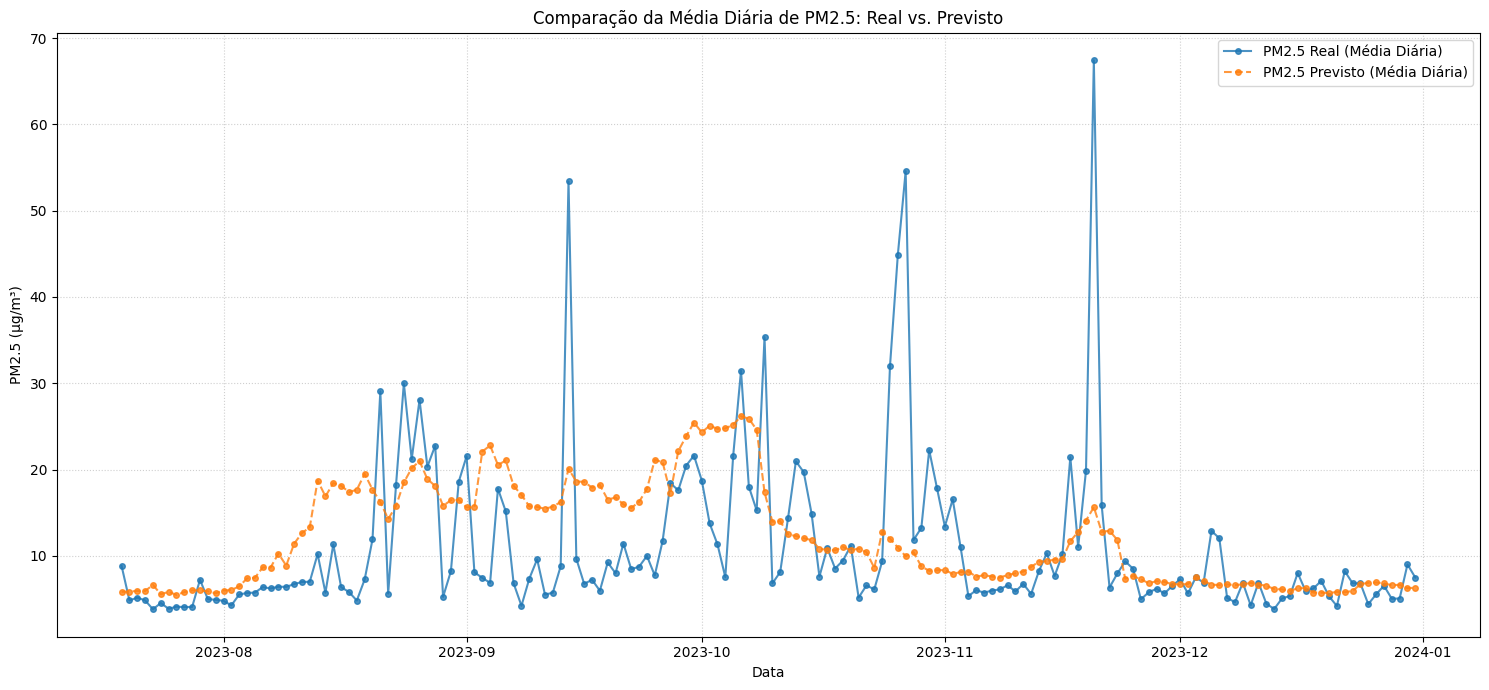

✓ Gráfico da média diária de PM2.5 salvo em 'pm10_daily_averages_plot.png'


In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(df_daily_avg['Data'], df_daily_avg['pm10_Target_Real_Daily_Avg'], label='PM2.5 Real (Média Diária)', marker='o', markersize=4, linestyle='-', alpha=0.8)
plt.plot(df_daily_avg['Data'], df_daily_avg['pm10_Prediction_Daily_Avg'], label='PM2.5 Previsto (Média Diária)', marker='o', markersize=4, linestyle='--', alpha=0.8)

plt.title('Comparação da Média Diária de PM2.5: Real vs. Previsto')
plt.xlabel('Data')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig('pm10_daily_averages_plot.png', dpi=300)
plt.show()

print("✓ Gráfico da média diária de PM2.5 salvo em 'pm10_daily_averages_plot.png'")